# Conditional VAE


## Library imports
The following code contains the required libraries for the notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

#import ...
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

>> Using device: cuda:0


## Fashion MNIST

In [2]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from functools import reduce


classes = [0, 1, 2]
n_classes = len(classes)
batch_size = 128
eval_batch_size = 64

# transforms into tensor, can be extend
transformations = transforms.Compose([transforms.ToTensor()]) 


# Define the train and test sets
dset_train = FashionMNIST("./", train=True,  transform=transformations, download=True)
dset_test  = FashionMNIST("./", train=False, transform=transformations)


def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

# load the datasets into DataLoader classes, sampler removed!
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.targets))
test_loader  = DataLoader(dset_test, batch_size=eval_batch_size, 
                          sampler=stratified_sampler(dset_test.targets))


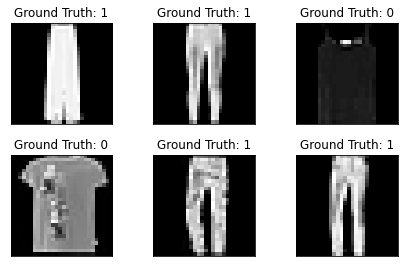

In [3]:
# https://nextjournal.com/gkoehler/pytorch-mnist
# Print from testset
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)


fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

plt.show()

## The Model 

inspired by: https://www.kaggle.com/ethanwharris/fashion-mnist-vae-with-pytorch-and-torchbearer

In [4]:
#https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
def final_loss(bce_loss, mu, logvar):
    BCE = bce_loss
    KLD = -.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD

### Previous architectures

```
self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=conv1[0],out_channels=conv1[1],kernel_size=conv1[2],stride=conv1[3],padding=conv1[4]),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=conv2[0],out_channels=conv2[1],kernel_size=conv2[2],stride=conv2[3],padding=conv2[4]),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=conv3[0],out_channels=conv3[1],kernel_size=conv3[2],stride=conv3[3],padding=conv3[4]),
        )
        
self.decoder = nn.Sequential(
    nn.ConvTranspose2d(in_channels=conv3[1],out_channels=conv3[0],kernel_size=conv3[2],stride=conv3[3],padding=conv3[4]),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(in_channels=conv2[1],out_channels=conv2[0],kernel_size=conv2[2],stride=conv2[3],padding=conv2[4],output_padding=1),
    nn.LeakyReLU(),
    nn.ConvTranspose2d(in_channels=conv1[1],out_channels=conv1[0],kernel_size=conv1[2],stride=conv1[3],padding=conv1[4]),
    )
```



In [6]:
def compute_conv_dim(w, f, p, s):
    """
    W = conv_dim (width_out / height_out)
    F = conv_kernel_dim
    P = conv_padding_dim
    S = conv_stride
    """
    return int(w - f + 2 * p) / s + 1

def swap_in_out(d):
    d = d.copy() # copy dict to not edit vals inplace
    n_in = d["in_channels"]
    d["in_channels"] = d["out_channels"]
    d["out_channels"] = n_in
    return d

NNprint_=True

class NNprint(torch.nn.Module):
    def forward(self, input):
        if NNprint_==True:
            print(input.shape)
        return input


In [7]:
# in, out, kernel, stride, padding
keys = ["in_channels", "out_channels", "kernel_size", "stride", "padding"]
conv1 = dict(zip(keys, [1, 32, 4, 1, 2]))
conv2 = dict(zip(keys, [conv1["out_channels"], 32, 4, 2, 1]))
conv3 = dict(zip(keys, [conv2["out_channels"], 64, 4, 2, 1]))

#deconv1 = swap_in_out(conv1)
#deconv2 = swap_in_out(conv2)
#deconv3 = swap_in_out(conv3)

deconv3 = dict(zip(keys, [64, 32, 4, 1, 2]))
deconv2 = dict(zip(keys, [deconv3["out_channels"], 32, 3, 2, 0]))
deconv1 = dict(zip(keys, [deconv2["out_channels"], 1, 4, 2, 0]))

##Look at 7.2 to see how to make encoder and decoder take non-fixed size image. 
class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_size, h_dim):
        super(VariationalAutoEncoder,self).__init__()
        self.latent_size = latent_size
        self.h_dim = h_dim
        
        self.encoder = nn.Sequential(
            nn.Conv2d(**conv1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=32), # num features fits previous channels_out
            nn.Conv2d(**conv2),
            nn.ReLU(),
            nn.Conv2d(**conv3),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(**deconv3),
            nn.ReLU(),
            nn.ConvTranspose2d(**deconv2),
            nn.ReLU(),
            nn.ConvTranspose2d(**deconv1),
            nn.ReLU(),
            )
        
        self.mu = nn.Linear(self.h_dim+n_classes, latent_size) # +1 for class label
        self.logvar = nn.Linear(self.h_dim+n_classes, latent_size) # +1 for class label
        self.upsample = nn.Linear(self.latent_size+n_classes, h_dim)
        
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)


    def generate(self, t):
      z = torch.randn(t.shape[0], self.latent_size).to(device)
      z = z.view(-1, self.latent_size)
      z = torch.cat((z, t), dim=-1)
      z = self.upsample(z)
      z = z.view(-1,64,7,7)
      z = self.decoder(z)
      return z

    # https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/    
    def forward(self, x, t):
        # encoding
        x = self.encoder(x)
        x = x.view(-1,self.h_dim) # flatten
        x = torch.cat((x,t), dim=-1) # concat one-hot class vector to x
        mu = self.mu(x)
        log_var = self.logvar(x)
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        # decoding
        z = torch.cat((z, t), dim=-1) # concat one-hot class vector to z
        z = self.upsample(z)

        z = z.view(-1,64,7,7) # shape to images

        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        
        return reconstruction, mu, log_var

h_dim = (64*7*7)
vae = VariationalAutoEncoder(latent_size, h_dim) # TODO: set z_dim to 16
print(vae)

# Test implementation
vae.to(device)
x = example_data[:2].to(device)
y = torch.nn.functional.one_hot(example_targets[:2], num_classes=n_classes).to(device)
o, m, lv = vae(x, y)
o.shape

VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
  )
  (mu): Linear(in_features=3139, out_features=15, bias=True)
  (logvar): Linear(in_features=3139, out_features=15, bias=True)
  (upsample): Linear(in_features=18, out_features=3136, bias=True)
)


torch.Size([2, 1, 28, 28])

### KL

### Visualisation

### Training

In [27]:
# settings
latent_size = 32
learning_rate = 1e-3

vae = VariationalAutoEncoder(latent_size=latent_size, h_dim=h_dim)
optimizer = optim.Adam(vae.parameters(),lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')

In [28]:
def fit_vae(vae, train_loader):
    vae.train()
    running_loss = 0.0
    # Run each batch in training dataset
    for x, y in train_loader:
        # x.view?
        x = x.to(device)
        y = torch.nn.functional.one_hot(y).to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = vae(x, y)
        bce_loss = criterion(reconstruction, x)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = running_loss/len(train_loader.dataset)
    return train_loss

def test_vae(vae, test_loader):
    vae.eval()
    running_loss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            # x.view?
            x = x.to(device)
            y = torch.nn.functional.one_hot(y).to(device)
            reconstruction, mu, logvar = vae(x, y)
            bce_loss = criterion(reconstruction, x)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
            
    val_loss = running_loss/len(test_loader.dataset)
    return val_loss
            

In [29]:
print(f">> Using device: {device}")
vae = vae.to(device)

train_loss = []
test_loss = []
num_epochs = 10

for current_epoch in range(num_epochs):
    print(f"Epoch {current_epoch+1} of {num_epochs}")
    train_epoch_loss = fit_vae(vae, train_loader)
    test_epoch_loss = test_vae(vae, test_loader)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {test_epoch_loss:.4f}")
    

>> Using device: cuda:0
Epoch 1 of 10
Train Loss: 158.3647
Val Loss: 155.0069
Epoch 2 of 10
Train Loss: 154.0056
Val Loss: 153.8406
Epoch 3 of 10
Train Loss: 153.4092
Val Loss: 153.5015
Epoch 4 of 10
Train Loss: 153.1810
Val Loss: 153.4171
Epoch 5 of 10
Train Loss: 152.9924
Val Loss: 153.2153
Epoch 6 of 10
Train Loss: 152.8531
Val Loss: 153.2032
Epoch 7 of 10
Train Loss: 152.7345
Val Loss: 153.2958
Epoch 8 of 10
Train Loss: 152.6951
Val Loss: 152.9656
Epoch 9 of 10
Train Loss: 152.6906
Val Loss: 152.9400
Epoch 10 of 10
Train Loss: 152.5404
Val Loss: 152.9682


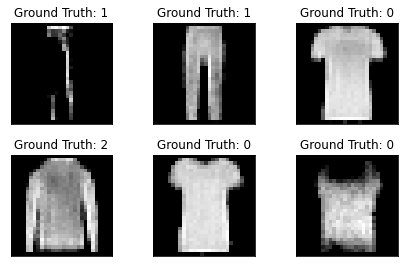

In [30]:
# examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
  output,_,_ = vae(example_data.to(device), torch.nn.functional.one_hot(example_targets).to(device))

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(output.cpu()[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig.show()

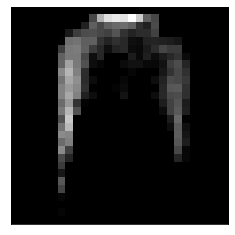

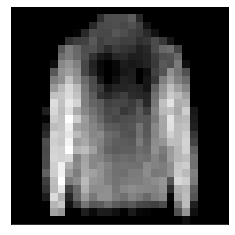

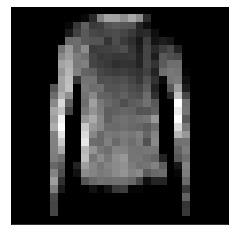

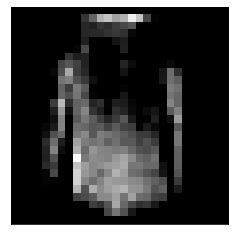

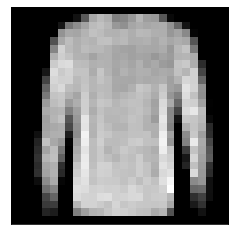

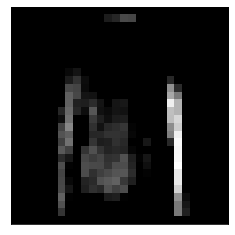

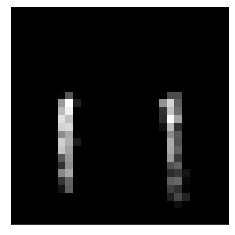

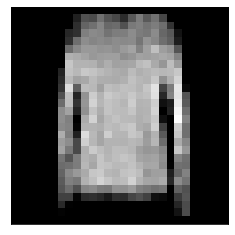

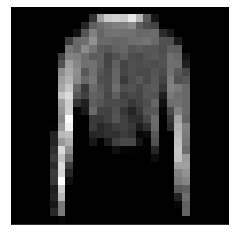

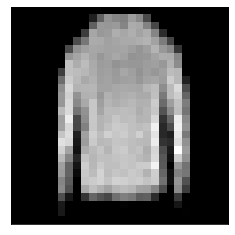

In [31]:
idx_class = 2
y = torch.ones(10) * idx_class
y = torch.nn.functional.one_hot(y.to(torch.int64), num_classes=n_classes).to(device)

with torch.no_grad():
  out = vae.generate(y)

for i in range(10):
  fig = plt.figure()
  plt.imshow(out.cpu()[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
  fig.show()